In [132]:
import torch
import numpy as np
import time
from PIL import Image
import skimage.segmentation
import skimage.color
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import evaluate
import pandas as pd
import json
import maxflow
import plotly.express as px
import pickle

# Find fastest device available
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

# Select backend for JIT compilation based on device (inductor is best but MPS only supports aot_eager)
jit_backend = "aot_eager" if device == "mps" else "inductor"

print("Using device:", device)
print("Using JIT backend:", jit_backend)

Using device: mps
Using JIT backend: aot_eager


## Algorithm

In [133]:
def find_nearest_compatible_size(numbers, target=14):
    remainders = numbers % target
    shape = numbers + (target - remainders)
    return shape

class GNEMNet_pretrained(torch.nn.Module):
    def __init__(self, image_size=(32,32), k=10, n_filters=16, dropout=0.2):
        super(GNEMNet_pretrained, self).__init__()
        self.embedding = cifar_classifier
        # get output size of embedding
        self.embedding.eval()
        with torch.no_grad():
            self.embedding_output_size = self.embedding(torch.zeros(1, 3, 32, 32).to(device)).shape[1]
        self.cluster = torch.nn.Linear(100, k)

    def forward(self, x):
        # upsample to self.embedding_input_size
        x = torch.nn.functional.interpolate(x, (32,32), mode="nearest")
        # normalize to mean 0.5 and std 0.5
        x = (x / 255)
        print(x.mean(), x.std())
        x = self.embedding(x)
        x = self.cluster(x)
        x = torch.softmax(x, dim=1)
        return x

class TileDS(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]
    
def tile(image, d):
    assert image.shape[0] % d == 0 or image.shape[1] % d == 0 # Image dimensions must be divisible by d
    tile_width = (image.shape[0] // d)
    tile_height = (image.shape[1] // d)
    image_tensor = torch.tensor(image, dtype=torch.float32)
    if len(image_tensor.shape) < 3:
        image_tensor = image_tensor.unsqueeze(2)
    tiles = image_tensor.unfold(0, tile_width, tile_height).unfold(1, tile_width, tile_height)
    tiles = tiles.permute(0, 1, 3, 4, 2)
    tiles = tiles.reshape(tiles.shape[0] * tiles.shape[1], tile_width, tile_height, tiles.shape[4])
    return tiles

def tile_with_overlap(image, d, overlap=2):
    assert image.shape[0] % d == 0 or image.shape[1] % d == 0 # Image dimensions must be divisible by d
    tile_width = (image.shape[0] // d)
    tile_height = (image.shape[1] // d)
    image_tensor = torch.tensor(image, dtype=torch.float32)
    # add padding to image
    image_tensor = torch.nn.functional.pad(image_tensor, (overlap,overlap,overlap,overlap))
    if len(image_tensor.shape) < 3:
        image_tensor = image_tensor.unsqueeze(2)
    # unfold with overlap
    tiles = image_tensor.unfold(0, tile_width + overlap, tile_height).unfold(1, tile_width + overlap, tile_height)
    tiles = tiles.permute(0, 1, 3, 4, 2)
    tiles = tiles.reshape(tiles.shape[0] * tiles.shape[1], tile_width + overlap, tile_height + overlap, tiles.shape[4])
    return tiles

def initial_labels(image, d, n_segments, method="slic"):
    if method == "slic":
        seg = skimage.segmentation.slic(image, compactness=1, max_num_iter=10,
                                        n_segments=n_segments, start_label=0,
                                        enforce_connectivity=False, convert2lab=True)
        
        # while len(np.unique(seg)) > n_segments, merge smallest segments
        while len(np.unique(seg)) > n_segments:
            # count number of pixels in each segment
            segments, counts = np.unique(seg, return_counts=True)
            # find smallest segment
            smallest1 = segments[np.argmin(counts)]
            # find second smallest segment
            counts[smallest1] = np.max(counts)
            smallest2 = segments[np.argmin(counts)]
            # merge smallest segments
            seg[seg == smallest1] = smallest2

        t = torch.tensor(seg).unsqueeze(0).unsqueeze(0).float()
        labels = torch.nn.functional.interpolate(t, (d, d), mode="nearest")
        labels = labels.squeeze().to(torch.int64).reshape(d * d)
        labels = torch.nn.functional.one_hot(labels, n_segments).float()
        return labels
    elif method == "random":
        labels = torch.randint(n_segments, (d * d,))
        labels = torch.nn.functional.one_hot(labels, n_segments).float()
        return labels

def graph_cut(probabilities, d, k, lambda_):
    lambda_ = lambda_
    # avoid division by zero
    probabilities[probabilities == 0] = 1e-10
    unary = -1 * np.log(probabilities.reshape(d, d, k))
    pairwise = (1 - np.eye(k)) * lambda_
    # result = gco.cut_grid_graph_simple(unary, pairwise)
    result = maxflow.aexpansion_grid(unary.astype(np.double), pairwise.astype(np.double))
    result = result.reshape(d * d)
    return result

def edge_align(pixelwise_predictions_, slic_segmentation_):
    start = time.time()
    pixelwise_predictions = pixelwise_predictions_.to(device) # (512, 512, 10)
    slic_segmentation = slic_segmentation_.to(device)
    slic_segment_indices = torch.unique(slic_segmentation).to(device)

    segmentation_shape = slic_segmentation.shape
    slic_segmentation = torch.flatten(slic_segmentation)
    segment_maps = (slic_segmentation.unsqueeze(0) == slic_segment_indices.unsqueeze(1)).reshape(len(slic_segment_indices), segmentation_shape[0], segmentation_shape[1]) # (916, 512, 512)

    batch_size = 128  # Adjust the batch size as needed
    num_batches = segment_maps.shape[0] // batch_size
    if segment_maps.shape[0] % batch_size != 0:
        num_batches += 1

    averages = []
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, segment_maps.shape[0])
        
        # Perform element-wise multiplication for the current batch
        batch_product = pixelwise_predictions.unsqueeze(0) * segment_maps[start_idx:end_idx].unsqueeze(-1)
        
        # Reshape the batch product to (512^2, 10)
        reshaped_product = batch_product.reshape(batch_product.shape[0], -1, pixelwise_predictions.shape[-1])
        
        # Calculate the average of non-zero elements along axis 0
        nonzero_count = reshaped_product.sum(dim=-1).count_nonzero(dim=1)
        nonzero_average = reshaped_product.sum(dim=1) / nonzero_count.unsqueeze(-1)

        # Append the average to the list
        averages.append(nonzero_average)

    averages = torch.cat(averages, dim=0)
    segment_predictions = averages.argmax(dim=1) # (916)

    # Create a broadcasted mask using broadcasting
    mask = slic_segmentation.unsqueeze(-1) == slic_segment_indices.unsqueeze(0)

    # Perform element-wise multiplication and sum along the second dimension
    integer_predictions = (mask.float() * segment_predictions.unsqueeze(0)).sum(dim=1)

    integer_predictions = integer_predictions.reshape(segmentation_shape)
    
    return integer_predictions


class GNEMS_Segmentor:
    def __init__(self, d=16, n_filters=16, dropout=0.2,
                lambda_=0.3, size=(512, 512), lr=0.001,
                iterations=100, subset_size=0.5,
                prediction_stride=1, slic_segments=100,
                sigma=3, compactness=10, seed=0, k=10, epochs=10,
                initialization_method="slic", epoch_schedule=None,
                max_epochs=40, min_epochs=10):
        self.d = d
        self.n_filters = n_filters
        self.dropout = dropout
        self.lambda_ = lambda_
        self.size = size
        self.tile_size = (size[0] // d, size[1] // d)
        self.lr = lr
        self.iterations = iterations
        self.subset_size = subset_size
        self.prediction_stride = prediction_stride
        self.seed = seed
        self.net = None
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.slic_segments = slic_segments
        self.sigma = sigma
        self.compactness = compactness
        self.k = k
        self.initial_labels = None
        self.epochs = epochs
        self.initialization_method = initialization_method
        self.epoch_schedule = epoch_schedule
        self.max_epochs = max_epochs
        self.min_epochs = min_epochs

    def fit(self, image):
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.image = image
        self.image_tensor = torch.from_numpy(image).to(device)

        assert image.shape[0] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[1] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[2] == 3 # image must channel last

        # Generate tiles and initial labels
        X = tile(image, d=self.d).type(torch.float32).to(device).permute(0, 3, 1, 2)
        y_initial = initial_labels(image, self.d, self.k, method=self.initialization_method).to(device)
        self.initial_labels = y_initial

        # Initialize CNN
        self.net = GNEMNet(image_size=self.image.shape[:2], tile_size=self.tile_size, n_filters=self.n_filters, dropout=self.dropout, k=self.k).to(device)
        
        # Initialize optimizer and loss function
        y_intermediate = y_initial.clone().detach().argmax(dim=1).type(torch.float32)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)

        # Train CNN
        itertimes = []
        graphtimes = []
        for iteration in range(self.iterations):
            start = time.time()
            shuffled_idx = torch.randperm(X.shape[0])
            X_shuffled = X[shuffled_idx]
            y_intermediate_shuffled = y_intermediate[shuffled_idx]
            X_subset = X_shuffled[:int(self.subset_size * X.shape[0])]
            y_intermediate_subset = y_intermediate_shuffled[:int(self.subset_size * X.shape[0])]
            n_epochs = self.epochs
            if self.epoch_schedule is not None:
                n_epochs = self.epoch_schedule(iteration, max_epochs=self.max_epochs, min_epochs=self.min_epochs, n_iter=self.iterations)
            for epoch in range(n_epochs):
                # Perform network step
                inputs = X_subset
                labels = y_intermediate_subset.type(torch.long)
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                self.losses.append(loss.item() / X.shape[0])
                loss.backward()
                optimizer.step()

            # DEBUG WITHOUT GRAPH
            # Set pseudo-labels to network output rounded to nearest integer
            outputs = self.net(X)
            # y_intermediate = outputs.argmax(dim=1).to(device)

            # Calculate probabilities for each tile
            probabilities = outputs.detach().squeeze(1).cpu().numpy()
            self.intermediate_probabilities.append(probabilities)

            # Skip graph step on last iteration
            if iteration != self.iterations - 1:
                # Perform graph step
                graph_start = time.time()
                partition = torch.tensor(graph_cut(probabilities, self.d, self.k, self.lambda_), dtype=torch.int64)
                partition = torch.nn.functional.one_hot(partition, self.k)
                self.intermediate_partitions.append(partition)
                graphtimes.append(time.time() - graph_start)

                # Update pseudo-labels
                y_intermediate = torch.Tensor(partition).to(device).argmax(dim=1).type(torch.long)

            itertimes.append(time.time() - start)
        # print(f"Average iteration time: {np.mean(itertimes)}")

    def predict_low_res(self):
        self.net.eval()
        X = tile(self.image, d=self.d).type(torch.float32).to(device).permute(0, 3, 1, 2)
        seg = self.net(X).detach().squeeze(1).reshape(self.d, self.d, self.k).cpu().numpy()
        return seg

    def predict(self, show_progress=True):
        self.net.eval()
        stride = self.prediction_stride
        image = self.image
        image_tensor = torch.tensor(image, dtype=torch.float32)
        all_tiles = image_tensor.unfold(0, self.tile_size[0], stride).unfold(1, self.tile_size[1], stride).reshape(-1, 3, self.tile_size[0], self.tile_size[1]).to(device)
        all_tiles_ds = TileDS(all_tiles)

        # set up dataloaders
        batch_size = 4096
        if device == "cuda":
            batch_size = 16384
        loader = torch.utils.data.DataLoader(all_tiles_ds, batch_size=batch_size, shuffle=False)
        n_batches = len(loader)

        with torch.no_grad():
            all_tiles_predictions = torch.zeros((len(all_tiles_ds), self.k)).to(device)
            iterator = tqdm(enumerate(loader), total=n_batches) if show_progress else enumerate(loader)
            for batch_i, batch in iterator:
                batch_predictions = self.net(batch)
                all_tiles_predictions[batch_i*loader.batch_size:(batch_i+1)*loader.batch_size] = batch_predictions.squeeze(1)

        predictions = all_tiles_predictions.reshape(((self.size[0] - self.tile_size[0]) // stride) + 1, ((self.size[1] - self.tile_size[1]) // stride) + 1, self.k)
        predictions = predictions.permute(2, 0, 1)

        pixelwise_probabilities = torch.nn.functional.interpolate(predictions.unsqueeze(0).unsqueeze(0), size=[self.k, image.shape[0], image.shape[1]], mode='trilinear')
        pixelwise_probabilities = pixelwise_probabilities.squeeze(0).squeeze(0).permute(1, 2, 0)
        segments = skimage.segmentation.slic(image, n_segments=self.slic_segments, sigma=self.sigma, compactness=self.compactness)
        segments = torch.tensor(segments).to(device)
        segmentation = edge_align(pixelwise_probabilities, segments)
        segmentation = segmentation.type(torch.uint8)
        # return segmentation
        return pixelwise_probabilities
    
    def predict_convolutional(self, show_progress=True):
        self.net.eval()
        self.net.enter_inference_mode()
        image_tensor = self.image_tensor.permute(2,0,1).unsqueeze(0).to(torch.float32)
        # image_tensor = torch.tensor(image, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
        seg = self.net(image_tensor)
        self.net.enter_training_mode()
        return seg
    
    def fit_convolutional(self, image):
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.image = image
        self.image_tensor = torch.from_numpy(image).to(device)

        assert image.shape[0] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[1] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[2] == 3 # image must channel last

        # Generate tiles and initial labels
        X = tile(image, d=self.d).type(torch.float32).to(device).permute(0, 3, 1, 2)
        y_initial = initial_labels(image, self.d, self.k, method=self.initialization_method).to(device)
        self.initial_labels = y_initial

        # Initialize CNN
        self.net = GNEMNet(image_size=self.image.shape[:2], tile_size=self.tile_size, n_filters=self.n_filters, dropout=self.dropout, k=self.k).to(device)
        
        # Initialize optimizer and loss function
        y_intermediate = y_initial.clone().detach().argmax(dim=1).type(torch.float32)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)

        # Train CNN
        itertimes = []
        graphtimes = []
        for iteration in range(self.iterations):
            start = time.time()
            shuffled_idx = torch.randperm(X.shape[0])
            X_shuffled = X[shuffled_idx]
            y_intermediate_shuffled = y_intermediate[shuffled_idx]
            X_subset = X_shuffled[:int(self.subset_size * X.shape[0])]
            y_intermediate_subset = y_intermediate_shuffled[:int(self.subset_size * X.shape[0])]
            n_epochs = self.epochs
            if self.epoch_schedule is not None:
                n_epochs = self.epoch_schedule(iteration, max_epochs=self.max_epochs, min_epochs=self.min_epochs, n_iter=self.iterations)
            for epoch in range(n_epochs):
                # Perform network step
                inputs = X_subset
                labels = y_intermediate_subset.type(torch.long)
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                self.losses.append(loss.item() / X.shape[0])
                loss.backward()
                optimizer.step()

            # DEBUG WITHOUT GRAPH
            # Set pseudo-labels to network output rounded to nearest integer
            outputs = self.net(X)
            # y_intermediate = outputs.argmax(dim=1).to(device)

            # Calculate probabilities for each tile
            probabilities = outputs.detach().squeeze(1).cpu().numpy()
            self.intermediate_probabilities.append(probabilities)

            # Skip graph step on last iteration
            if iteration != self.iterations - 1:
                # Perform graph step
                graph_start = time.time()
                partition = torch.tensor(graph_cut(probabilities, self.d, self.k, self.lambda_), dtype=torch.int64)
                partition = torch.nn.functional.one_hot(partition, self.k)
                self.intermediate_partitions.append(partition)
                graphtimes.append(time.time() - graph_start)

                # Update pseudo-labels
                y_intermediate = torch.Tensor(partition).to(device).argmax(dim=1).type(torch.long)

            itertimes.append(time.time() - start)
        # print(f"Average iteration time: {np.mean(itertimes)}")

In [283]:
class GNEMNet_FCN(torch.nn.Module):
    def __init__(self, image_size=(512,512), tile_size=(32,32), k=25, n_filters=16, dropout=0.2, subset_size=0.5):
        super(GNEMNet_FCN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, n_filters, 3, padding=1, stride=1)
        self.BN1 = torch.nn.BatchNorm2d(n_filters)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(n_filters, 1, 3, padding=1, stride=1)
        self.BN2 = torch.nn.BatchNorm2d(1)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.output = torch.nn.Conv2d(1, k, 1, padding=0, stride=1)
        self.training_mode = True
        self.tile_size = tile_size
        self.subset_size = subset_size
        num_patches_total = (image_size[0] // tile_size[0]) * (image_size[1] // tile_size[1])
        self.training_patch_indices = torch.arange(0, round(num_patches_total * subset_size), dtype=torch.int)
        self.training_patch_indices_have_changed = True
        self.patches_to_train_on = None

    def enter_training_mode(self):
        self.training_mode = True
    
    def enter_inference_mode(self):
        self.training_mode = False

    def set_training_patch_indices(self, indices):
        self.training_patch_indices = torch.tensor(indices, dtype=torch.int)
        self.training_patch_indices_have_changed = True

    def forward(self, x):
        if self.training_mode:
            if self.training_patch_indices_have_changed:
                patches = torch.nn.functional.unfold(x, kernel_size=self.tile_size, stride=self.tile_size, dilation=1, padding=0)
                patches = patches.view(3, self.tile_size[0], self.tile_size[1], -1).permute(3, 0, 1, 2)
                self.training_patch_indices_have_changed = False
                self.patches_to_train_on = patches[self.training_patch_indices]

            x = self.patches_to_train_on

        x = self.conv1(x)
        x = self.BN1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.BN2(x)
        x = torch.relu(x)
        x = self.dropout2(x)

        x = self.output(x)

        if self.training_mode:
            x = torch.nn.functional.avg_pool2d(x, self.tile_size, stride=self.tile_size, padding=0)

        x = torch.softmax(x, dim=1)
        return x
    
net = GNEMNet_FCN().to("mps")
net.enter_training_mode()

image = plt.imread("synthetic_color_images/0.0/0001.png")[:,:,:3]
image = torch.tensor(image).to("mps").unsqueeze(0).permute(0, 3, 1, 2)
out = net(image)

def test_forward_training():
    net = GNEMNet_FCN().to("mps")
    net.enter_training_mode()
    for i in range(111):
        out = net(torch.ones((1,3,512,512)).to("mps"))
    print("Training Mode Output Shape:", out.shape)

def test_forward_inference():
    net = GNEMNet_FCN().to("mps")
    net.enter_inference_mode()
    for i in range(111):
        if i % 30 == 0:
            net.set_training_patch_indices(net.training_patch_indices)
        out = net(torch.ones((1,3,512,512)).to("mps"))
    print("Inference Mode Output Shape:", out.shape)
        
%time test_forward_training()
%time test_forward_inference()

Training Mode Output Shape: torch.Size([128, 25, 1, 1])
CPU times: user 222 ms, sys: 128 ms, total: 350 ms
Wall time: 409 ms


/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_58798/3855321543.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.training_patch_indices = torch.tensor(indices, dtype=torch.int)


Inference Mode Output Shape: torch.Size([1, 25, 512, 512])
CPU times: user 250 ms, sys: 135 ms, total: 385 ms
Wall time: 546 ms


In [141]:
# Define CNN module for GNEMS to use
class GNEMNet(torch.nn.Module):
    def __init__(self, image_size=(512,512), tile_size=(32,32), k=10, n_filters=16, dropout=0.2):
        print("tile_size", tile_size)
        super(GNEMNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, n_filters, 3, padding=1, padding_mode='zeros')
        self.BN1 = torch.nn.BatchNorm2d(n_filters)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(n_filters, 1, 3, padding=1, padding_mode='zeros')
        self.BN2 = torch.nn.BatchNorm2d(1)
        self.dropout2 = torch.nn.Dropout(dropout)
        # self.conv_debug = torch.nn.Conv2d(3, 1, 3, padding=1)
        self.train_output = torch.nn.Linear((tile_size[0] - 0) * (tile_size[1] - 0), k)
        # self.inference_output = torch.nn.Conv2d(1, k, tile_size, padding=((np.array(tile_size) - 1) // 2).tolist())
        self.inference_output = torch.nn.Conv2d(1, k, ((tile_size[0] - 0), (tile_size[1] - 0)), padding=0, stride=1)
        self.output = self.train_output
        self.is_inference_mode = False

    def enter_inference_mode(self):
        self.is_inference_mode = True
        # get weights from self.output
        weights = self.train_output.weight.data
        bias = self.train_output.bias.data
        # set weights and bias to predictor
        self.inference_output.weight.data = weights.reshape(self.inference_output.weight.shape)
        
        self.inference_output.bias.data = bias
        # set output to inference_output
        self.output = self.inference_output

    def enter_training_mode(self):
        self.is_inference_mode = False
        # get weights from self.output
        weights = self.inference_output.weight.data
        bias = self.inference_output.bias.data
        # set weights and bias to predictor
        self.train_output.weight.data = weights.reshape(self.train_output.weight.shape)
        self.train_output.bias.data = bias
        # set output to inference_output
        self.output = self.train_output

    def forward(self, x):
        # x = self.conv_debug(x)
        x = self.conv1(x)
        x = self.BN1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        # print(x.shape)
        if not self.is_inference_mode:
            x = torch.flatten(x,1)
        x = self.output(x)
        x = torch.softmax(x, dim=1)
        return x

ValueError: expected 4D input (got 3D input)

tile_size (16, 16)
Training Time: 2.5425219535827637
Dense Prediction Time: 0.44006800651550293
Convolutional Prediction Time: 0.002691984176635742


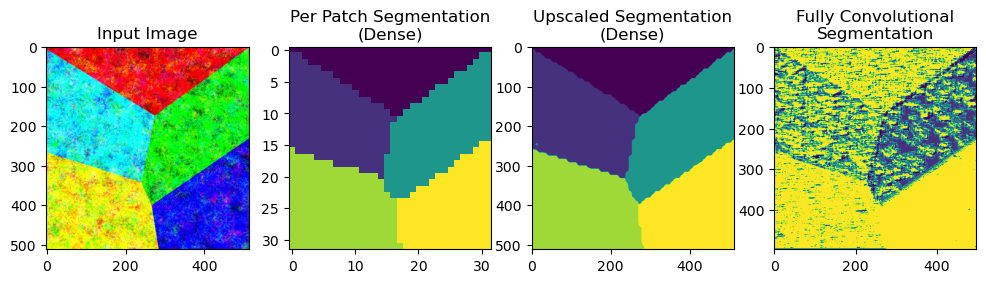

In [139]:
def epoch_schedule(x_, max_epochs=40, min_epochs=10, n_iter=4):
    return_int = False
    if not isinstance(x_, np.ndarray):
        x = np.array([x_])
        return_int = True
    else:
        x = x_
    x[x == 0] = 1
    v = ((5*n_iter)/x) + min_epochs
    too_high = v > max_epochs
    v[too_high] = max_epochs
    # convert to int
    v = v.astype(int)
    if return_int:
        return v[0]
    else:
        return v

image = np.array(Image.open("synthetic_color_images/0.2/0001.png").resize((512,512)))[:,:,:3]
k = 25
d = 32
lambda_ = 4

start_time = time.time()
train_start = time.time()
segmentor = GNEMS_Segmentor(iterations=8, k=k, d=d, lambda_=lambda_,
                            subset_size=0.5, lr=0.005, epochs=10, n_filters=16,
                            slic_segments=500, prediction_stride=8,
                            initialization_method="slic", compactness=10, sigma=2,
                            epoch_schedule=epoch_schedule, max_epochs=40, min_epochs=10)
segmentor.fit(image)
train_end = time.time()
print("Training Time:", train_end - train_start)

prediction_start = time.time()
seg = segmentor.predict(show_progress=False)
prediction_end = time.time()
print("Dense Prediction Time:", prediction_end - prediction_start)

end_time = time.time()

def side_by_side(images, titles=None, height=3):
    fig, axes = plt.subplots(1, len(images), figsize=(height*len(images), height))
    for i, image in enumerate(images):
        axes[i].imshow(image)
        if titles is not None:
            axes[i].set_title(titles[i])
    plt.show()

conv_prediction_start = time.time()
conv_seg = segmentor.predict_convolutional()
conv_prediction_end = time.time()
print("Convolutional Prediction Time:", conv_prediction_end - conv_prediction_start)
conv_seg_raw = conv_seg
conv_seg = conv_seg.permute(0,2,3,1).squeeze(0).argmax(dim=2).cpu().numpy()

lowres_seg = np.argmax(segmentor.predict_low_res(), axis=2)

side_by_side([image, lowres_seg, seg.argmax(dim=2).cpu().numpy(), conv_seg], titles=["Input Image", "Per Patch Segmentation\n(Dense)", "Upscaled Segmentation\n(Dense)", "Fully Convolutional\nSegmentation"])

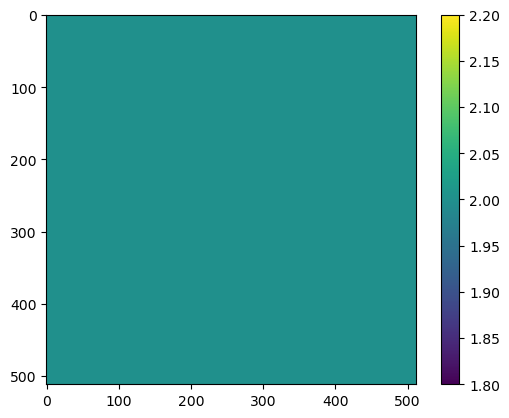

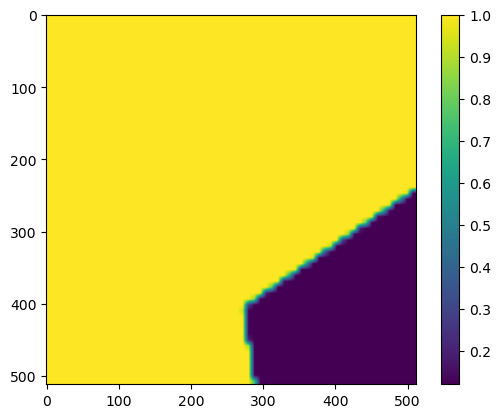

tensor([0.0265, 0.0365, 0.1201, 0.0289, 0.0292, 0.0580, 0.0249, 0.0261, 0.0283,
        0.0507, 0.0291, 0.0529, 0.0291, 0.0501, 0.0264, 0.0566, 0.0278, 0.0276,
        0.0274, 0.0369, 0.0476, 0.0601, 0.0271, 0.0343, 0.0379],
       device='mps:0')


In [38]:
plt.imshow(seg.argmax(axis=2).cpu().numpy())
plt.colorbar()
plt.show()
plt.imshow(seg[:,:,2].cpu().numpy())
plt.colorbar()
plt.show()
print(seg[511,511,:])

torch.Size([1024, 1, 12, 12])


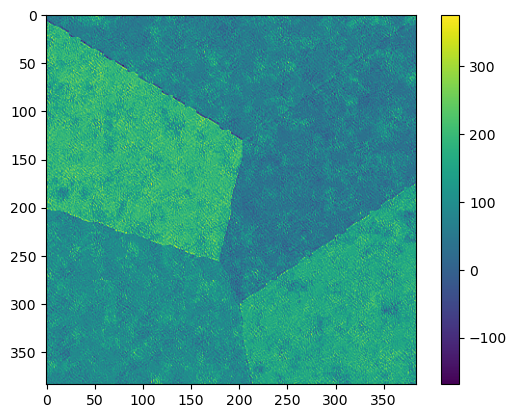

torch.Size([1, 1, 508, 508])


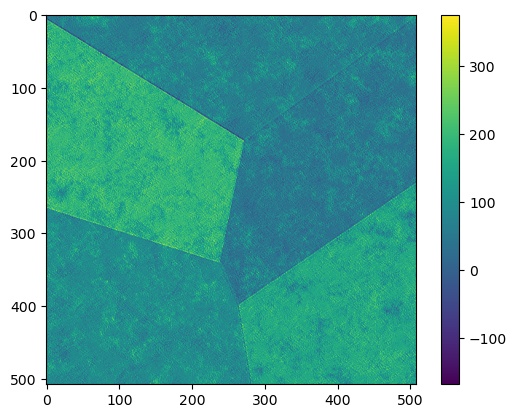

In [108]:
patches = tile(image, 32).permute(0,3,1,2).to("mps")
responses = segmentor.net.conv1(patches)
responses = segmentor.net.conv2(responses)
print(responses.shape)
conv2_patch_responses = responses
# convert 0th dimension to list
rows = []
for j in range(32):
    row = torch.cat([responses[(i*32) + j] for i in range(32)], dim=1)
    rows.append(row)
responses = torch.cat(rows, dim=2)
responses = responses.cpu().detach().permute(1,2,0).numpy()[:,:,:3]
dense_style_responses = responses
plt.imshow(responses)
plt.colorbar()
plt.show()

responses = segmentor.net.conv1(torch.tensor(image, dtype=torch.float32).to("mps").unsqueeze(0).permute(0,3,1,2))
responses = segmentor.net.conv2(responses)
print(responses.shape)
conv2_image_responses = responses
responses = responses.cpu().squeeze(0).detach().permute(1,2,0).numpy()[:,:,:3]
conv_style_responses = responses
plt.imshow(responses)
plt.colorbar()
plt.show()

# plt.imshow(conv_style_responses - dense_style_responses)
# plt.colorbar()
# plt.show()

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_58507/3985556701.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(image, dtype=torch.float32)


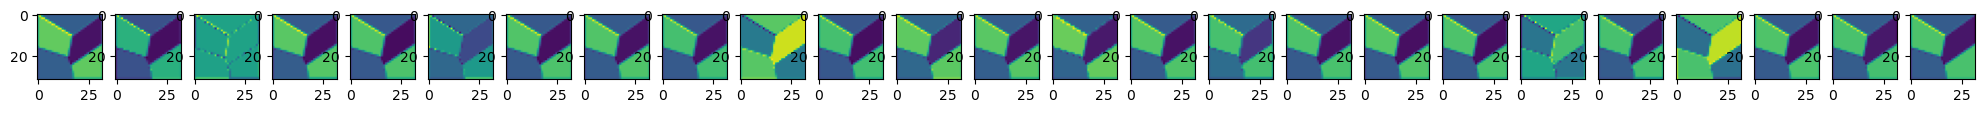

In [115]:
input_ = conv2_image_responses.squeeze(0).squeeze(0)
# print()
patches = tile(input_, 32).permute(0,3,1,2).to("mps")
# patches = conv2_patch_responses
lin = torch.nn.Linear(16*16, 25).to("mps")
lin.weight.data = segmentor.net.train_output.weight.data
lin.bias.data = segmentor.net.inference_output.bias.data
inputs = patches.flatten(2)[:,0,:].to("mps")
out = lin(inputs).reshape(32,32,25).to("cpu").detach().numpy()
side_by_side([out[:,:,i] for i in range(25)], height=1)
# plt.imshow(out[:,:,1])
# plt.colorbar()

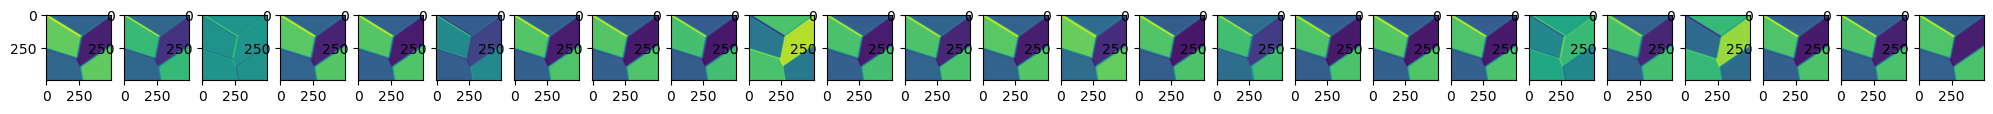

In [116]:
# input_ = torch.tensor(image, dtype=torch.float32).to("mps").unsqueeze(0).permute(0,3,1,2)[:,0,:,:]
responses = segmentor.net.conv1(torch.tensor(image, dtype=torch.float32).to("mps").unsqueeze(0).permute(0,3,1,2))
responses = segmentor.net.conv2(responses)
conv2_image_responses = responses
input_ = conv2_image_responses
conv_weights = segmentor.net.inference_output.weight.data
conv = torch.nn.Conv2d(1, 25, 32, 1).to("mps")
conv.weight.data = conv_weights
conv.bias.data = segmentor.net.inference_output.bias.data
out = conv(input_).squeeze(0).permute(1,2,0).to("cpu").detach().numpy()

side_by_side([out[:,:,i] for i in range(25)], height=1)
# plt.imshow(out[:,:,1])
# plt.colorbar()

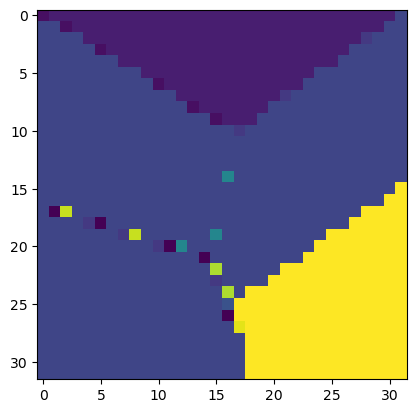

In [27]:
patches = tile(image, 32).permute(0,3,1,2).to("mps")
responses = segmentor.net.conv1(patches)
responses = segmentor.net.conv2(responses)
responses = segmentor.net.train_output(torch.flatten(responses, 1))
responses = responses.reshape(32,32,25).to("cpu").detach().numpy()
plt.imshow(responses.argmax(axis=2))

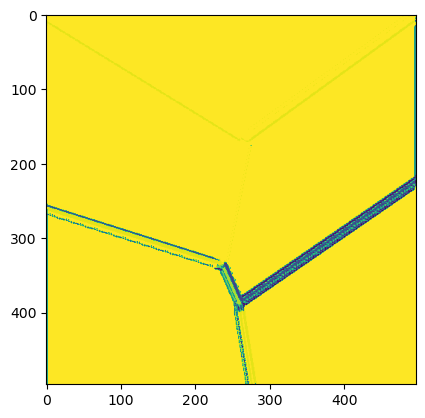

In [35]:
responses = segmentor.net.conv1(torch.tensor(image, dtype=torch.float32).to("mps").unsqueeze(0).permute(0,3,1,2))
responses = segmentor.net.conv2(responses)
# responses = segmentor.net.inference_output(responses)
# responses = responses.squeeze(0).permute(1,2,0).cpu().detach().numpy()

conv_weights = segmentor.net.inference_output.weight.data
conv = torch.nn.Conv2d(1, 25, 32).to("mps")
conv.weight.data = conv_weights
conv.bias.data = segmentor.net.inference_output.bias.data
out = conv(responses).squeeze(0).permute(1,2,0).to("cpu").detach().numpy()
plt.imshow(out.argmax(axis=2))

In [125]:
conv_seg_raw.squeeze(0).permute(1,2,0)[25,25,:] in seg

False

In [128]:
seg.shape

torch.Size([512, 512, 25])

In [177]:
t = torch.ones(256).to(device)
o = segmentor.net.train_output(t)
print(o.shape)
o.argmax(dim=0)

torch.Size([25])


tensor(13, device='mps:0')

In [173]:
segmentor.net.inference_output(torch.ones((1,32,32)).to(device)).permute(1,2,0).argmax(dim=2)

tensor([[13, 13],
        [13, 13]], device='mps:0')

In [181]:
test_img = np.array([[[255,0,0],[255,0,0],[0,255,0],[0,255,0]],
                     [[255,0,0],[255,0,0],[0,255,0],[0,255,0]],
                     [[0,0,255],[0,0,255],[255,0,255],[255,0,255]],
                     [[0,0,255],[0,0,255],[255,0,255],[255,0,255]]])

tile_size (2, 2)


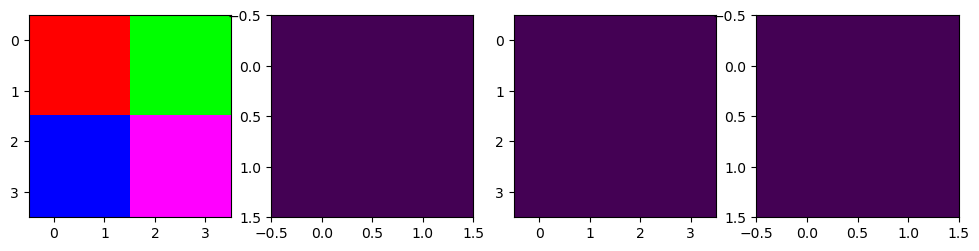

In [187]:
def epoch_schedule(x_, max_epochs=40, min_epochs=10, n_iter=4):
    return_int = False
    if not isinstance(x_, np.ndarray):
        x = np.array([x_])
        return_int = True
    else:
        x = x_
    x[x == 0] = 1
    v = ((5*n_iter)/x) + min_epochs
    too_high = v > max_epochs
    v[too_high] = max_epochs
    # convert to int
    v = v.astype(int)
    if return_int:
        return v[0]
    else:
        return v

image = test_img
k = 10
d = 2
lambda_ = 4

device = "cpu"

start_time = time.time()
train_start = time.time()
segmentor = GNEMS_Segmentor(size=image.shape[:2], iterations=8, k=k, d=d, lambda_=lambda_,
                            subset_size=0.5, lr=0.005, epochs=40, n_filters=16,
                            slic_segments=500, prediction_stride=8,
                            initialization_method="random", compactness=10, sigma=2,
                            epoch_schedule=epoch_schedule, max_epochs=40, min_epochs=10)
segmentor.fit(image)
train_end = time.time()

prediction_start = time.time()
seg = segmentor.predict(show_progress=False)
prediction_end = time.time()
end_time = time.time()

def side_by_side(images, height=3):
    fig, axes = plt.subplots(1, len(images), figsize=(height*len(images), height))
    for i, image in enumerate(images):
        axes[i].imshow(image)
    plt.show()
    
conv_seg = segmentor.predict_convolutional()
conv_seg_raw = conv_seg
conv_seg = conv_seg.permute(0,2,3,1).squeeze(0).argmax(dim=2).cpu().numpy()
lowres_seg = np.argmax(segmentor.predict_low_res(), axis=2)
side_by_side([image, lowres_seg, seg.argmax(dim=2).cpu().numpy(), conv_seg])

In [ ]:
plt.imshow()

In [210]:
segmentor.net.inference_output(torch.tensor(image[:,:,0:1], dtype=torch.float32).permute(2,0,1).to(device)).permute(1,2,0).argmax(dim=2)
torch.tensor(image[:,:,0:1], dtype=torch.float32).permute(2,0,1).to(device).shape

torch.Size([1, 4, 4])

In [204]:
segmentor.net.train_output(torch.tensor(image[:,:,0:1], dtype=torch.float32).permute(2,0,1).to(device)).argmax(dim=1)

tensor([[2, 0, 0, 0, 0, 0, 2, 0, 0, 2]])